In [2]:
# Imports
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import pickle

# Import
# Math
import numpy as np
import matplotlib.pyplot as plt
import math as m

# File Handling
from sys import getsizeof
import _pickle as pickle
# Alternatively use JSON which will be human readable
# import json

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Custom imports
from MarketGeneratingFunctions.global_cache import Global_Cache
import MarketGeneratingFunctions.base_from_gen as bg
import MarketGeneratingFunctions.pricing_func as pf
from MarketGeneratingFunctions.path_datatype import Path

In [3]:
with open("ZeroCorrTest","rb") as fp:   # Set Test Data according to what it's trained on
    path = pickle.load(fp)

path = path[0] # Change for different paths

In [11]:
# Define Hedge Tracker
hedgeS = []
hedgeQ = []
mktpnl= []
trcosts = []

# Set Transaction Costs
transaction = True

### Delta Hedged PnL
if not 'T_s' in vars() or 'T_s' in globals():
    T_s = np.arange(0,21)
from MarketGeneratingFunctions import DeltaHedge

pnl = np.zeros(len(path.CVA)-1)
swptOldPos = 0
qOldPos = 0
for i in range(len(path.CVA)-1):
    t = path.t_s[i]
    Q = [1] + [path.Q_s[j][i] for j in range(1,21)]
    Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]
    T_sl = T_s.copy()
        
    [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,Q,T_sl,t)

    # Do nothing hack
    SwapsHedge = SwapsHedge*0
    Qhedge = Qhedge*0

    hedgeS.append(SwapsHedge)#np.concat(SwapsHedge,Qhedge)
    hedgeQ.append(Qhedge)

    cost = np.inner(SwapsHedge,Swapts) + np.inner(Qhedge,Q)
    trCost = np.inner(np.abs(swptOldPos-SwapsHedge),Swapts) + np.inner(np.abs(qOldPos-Qhedge),Q)
        
    futureSwapts = [0] + [path.Swaptions[j][i+1] for j in range(0,19)]
    futureQ = [path.Q_s[j][i+1] for j in range(0,21)]
    value = np.inner(SwapsHedge,futureSwapts) + np.inner(Qhedge,futureQ)

    mktpnl.append((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    trcosts.append(trCost*0.02)

    if transaction==True:
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost)) - trCost*0.02
    else:
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
            
    swptOldPos = SwapsHedge
    qOldPos = Qhedge


In [ ]:
hedgeS = []
hedgeQ = []
mktpnl= []
trcosts = []


### Bimonthly Delta Hedged PnL
pnl = np.zeros(len(path.CVA)-1)
swptOldPos = 0
qOldPos = 0
for i in range(len(path.CVA)-1):
    t = path.t_s[i]
    Q = [1] + [path.Q_s[j][i] for j in range(1,21)]
    Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]
    T_sl = T_s.copy()
    
    if i%42 == 0:
        [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,Q,T_sl,t)
    hedgeS.append(SwapsHedge)#np.concat(SwapsHedge,Qhedge)
    hedgeQ.append(Qhedge)

    cost = np.inner(SwapsHedge,Swapts) + np.inner(Qhedge,Q)
    trCost = np.inner(np.abs(swptOldPos-SwapsHedge),Swapts) + np.inner(np.abs(qOldPos-Qhedge),Q)
        
    futureSwapts = [0] + [path.Swaptions[j][i+1] for j in range(0,19)]
    futureQ = [path.Q_s[j][i+1] for j in range(0,21)]
    value = np.inner(SwapsHedge,futureSwapts) + np.inner(Qhedge,futureQ)

    mktpnl.append((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    trcosts.append(trCost*0.02)

    if transaction==True:
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost)) - trCost*0.02
    else:
            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
            
    swptOldPos = SwapsHedge
    qOldPos = Qhedge


In [ ]:
hedgeS = []
hedgeQ = []
mktpnl= []
trcosts = []


### AI Hedged PnL
modelG = PPO.load("logs/models/trcoste7/best_model.zip") #<- Set model to load, should be auto from here
action_scale = 2

pnl = np.zeros(len(path.CVA)-1)
swptOldPos = 0
qOldPos = 0
for i in range(round((len(path.CVA)-1))):
    # Get State
    lambdax = np.tanh(np.log((path.lambdas[i] - 0.001)+1)) if path.lambdas[i] != -0.999 else -1
    r = np.tanh(path.r[i]) 
    t = path.t_s[i]/10 - 1

    Q = [path.Q_s[j][i] for j in range(1,21)]
    Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]

    Sobs = np.tanh(np.log([a+1 for a in Swapts]))
    Qobs = [(a - 0.5)*2 for a in Q] 

    futureQ = [path.Q_s[j][i+1] for j in range(1,21)]
    futureSwapts = [0.0] + [path.Swaptions[j][i+1] for j in range(0,19)]

    # Create Hedge
    #hedgPos = modelG.predict(np.asmatrix([lambdax,r,t]), deterministic = True)   #<-  If you're using a model with xs observation space
    hedgPos = modelG.predict(np.concat([Sobs,Qobs]), deterministic = True)      #<- If you're using a model with full observation space
    #hedgPos = hedgPos[0][0]                                                     #<-  If you're using a model with xs observation space
    hedgPos = hedgPos[0]                                                       #<- If you're using a model with full observation space

    if len(hedgPos) == 2:
        swpt = hedgPos[0]
        Qq = hedgPos[1]
        hedgPos = np.concatenate([np.zeros(19), [swpt], np.zeros(19), [Qq]])*action_scale
    if len(hedgPos) == 40:
        hedgPos = hedgPos*0.1

    swpPos = hedgPos[0:20]
    QPos = hedgPos[20:]

    hedgeS.append(swpPos)#np.concat(SwapsHedge,Qhedge)
    hedgeQ.append(QPos)


    trCost = np.inner(np.abs(swptOldPos-swpPos),Swapts) + np.inner(np.abs(qOldPos-QPos),Q)

    cost = np.sum(np.inner(swpPos,Swapts) + np.inner(QPos,Q))
    value = np.sum(np.inner(swpPos,futureSwapts) + np.inner(QPos,futureQ))

    mktpnl.append((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    trcosts.append(trCost*0.02)

    if transaction:
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost)) - trCost*0.02
    else:
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))

    swptOldPos = swpPos
    qOldPos = QPos



MovieWriter ffmpeg unavailable; using Pillow instead.


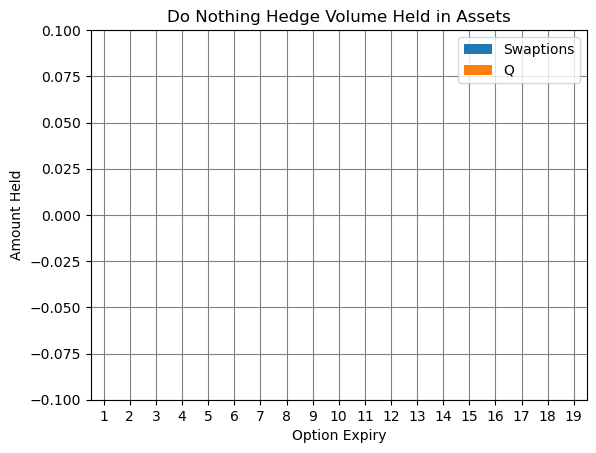

In [8]:
from matplotlib import animation

# Plot the Hedge at a given time step
fig, ax = plt.subplots()
barS = ax.bar(np.arange(1,20)-0.2,hedgeS[0][:-1], width = 0.4, label = 'Swaptions')
barQ = ax.bar(np.arange(1,20)+0.2,hedgeQ[0][1:-1], width = 0.4, label = 'Q')

ax.set_axisbelow(True)
ax.grid(color = 'grey')

ax.set_xlim(0.5,19.5)
ax.set_xticks(np.arange(1,20))
ax.set_xticklabels(np.arange(1,20));
ax.set_ylabel("Amount Held")
ax.set_xlabel("Option Expiry")

ax.legend()
ax.set_ylim([-0.1,0.1])

plt.title('Do Nothing Hedge Volume Held in Assets')

def update(frame):  
    yS = hedgeS[frame][:-1]
    for i , b in enumerate(barS):
        b.set_height(yS[i])
    
    yQ = hedgeQ[frame][:-1]
    for i , b in enumerate(barQ):
        b.set_height(yQ[i])
    

ani = animation.FuncAnimation(fig = fig, func = update, frames = 5*252, interval = 60)
ani.save('DNPosition.gif')

plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


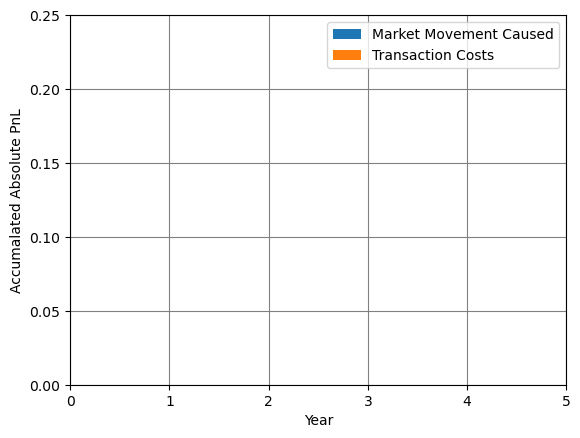

In [9]:
fig, ax = plt.subplots()
stck = ax.stackplot(range(252*5), np.cumsum(np.abs(mktpnl[0:252*5])), np.cumsum(np.abs(trcosts[0:252*5])), labels=['Market Movement Caused','Transaction Costs'],baseline = 'zero')

plt.title("Absolute daily PnL Do Nothing")

def update(frame):
    ax.clear()
    ax.stackplot(range(frame), np.cumsum(np.abs(mktpnl[0:frame])), np.cumsum(np.abs(trcosts[0:frame])), labels=['Market Movement Caused','Transaction Costs'],baseline = 'zero')
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(color = 'grey')
    ax.set_xlim([0,252*5])
    ax.set_xticks(np.arange(0,6)*252, [0, 1, 2, 3, 4, 5])
    ax.set_xlabel("Year")
    ax.set_ylabel("Accumalated Absolute PnL")
    ax.set_ylim([0,0.25])


ani = animation.FuncAnimation(fig = fig, func = update, frames = 5*252, interval = 60)
ani.save('DNPerf.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


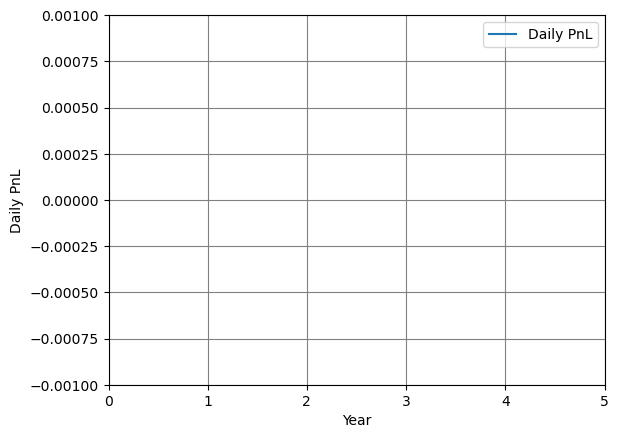

In [10]:
fig, ax = plt.subplots()
pltPnl = [a - b for a,b in zip(mktpnl,trcosts)]

plt.title("PnL by Day Do Nothing")

def update(frame):
    ax.clear()
    ax.plot(range(frame), pltPnl[0:frame], label = 'Daily PnL')
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(color = 'grey')
    ax.set_xlim([0,252*5])
    ax.set_ylim([-0.001,0.001])
    ax.set_xticks(np.arange(0,6)*252, [0, 1, 2, 3, 4, 5])
    ax.set_xlabel("Year")
    ax.set_ylabel("Daily PnL")


ani = animation.FuncAnimation(fig = fig, func = update, frames = 5*252, interval = 60)
ani.save('DNPnl.gif')